## Обзор

### Описание проекта

Компания «F9» — это российская авиакомпания, выполняющая внутренние пассажирские авиаперевозки. 

Цель: понять предпочтения пользователей, покупающих билеты на те или иные направления.

Предстоит изучить базу данных и проанализировать спрос пассажиров на рейсы в города, где проходят крупнейшие фестивали.

### Описание данных

База данных об авиаперевозках:

**Таблица airports** — информация об аэропортах:

- airport_code — трёхбуквенный код аэропорта,
- airport_name — название аэропорта,
- city — город,
- timezone — часовой пояс.

**Таблица aircrafts** — информация о самолётах:

- aircraft_code — код модели самолёта,
- model — модель самолёта,
- range — дальность полётов.

**Таблица tickets** — информация о билетах:

- ticket_no — уникальный номер билета,
- passenger_id — уникальный идентификатор пассажира,
- passenger_name — имя и фамилия пассажира.

**Таблица flights** — информация о рейсах:

- flight_id — уникальный идентификатор рейса,
- departure_airport — аэропорт вылета,
- departure_time — дата и время вылета,
- arrival_airport — аэропорт прилёта,
- arrival_time — дата и время прилёта,
- aircraft_code — уникальный идентификатор самолёта.

**Таблица ticket_flights** — стыковая таблица «рейсы-билеты»:

- ticket_no — номер билета,
- flight_id — уникальный идентификатор рейса.

**Таблица festivals** — информация о фестивалях:

- festival_id — уникальный номер фестиваля,
- festival_date — дата проведения фестиваля,
- festival_city — город проведения фестиваля,
- festival_name — название фестиваля.

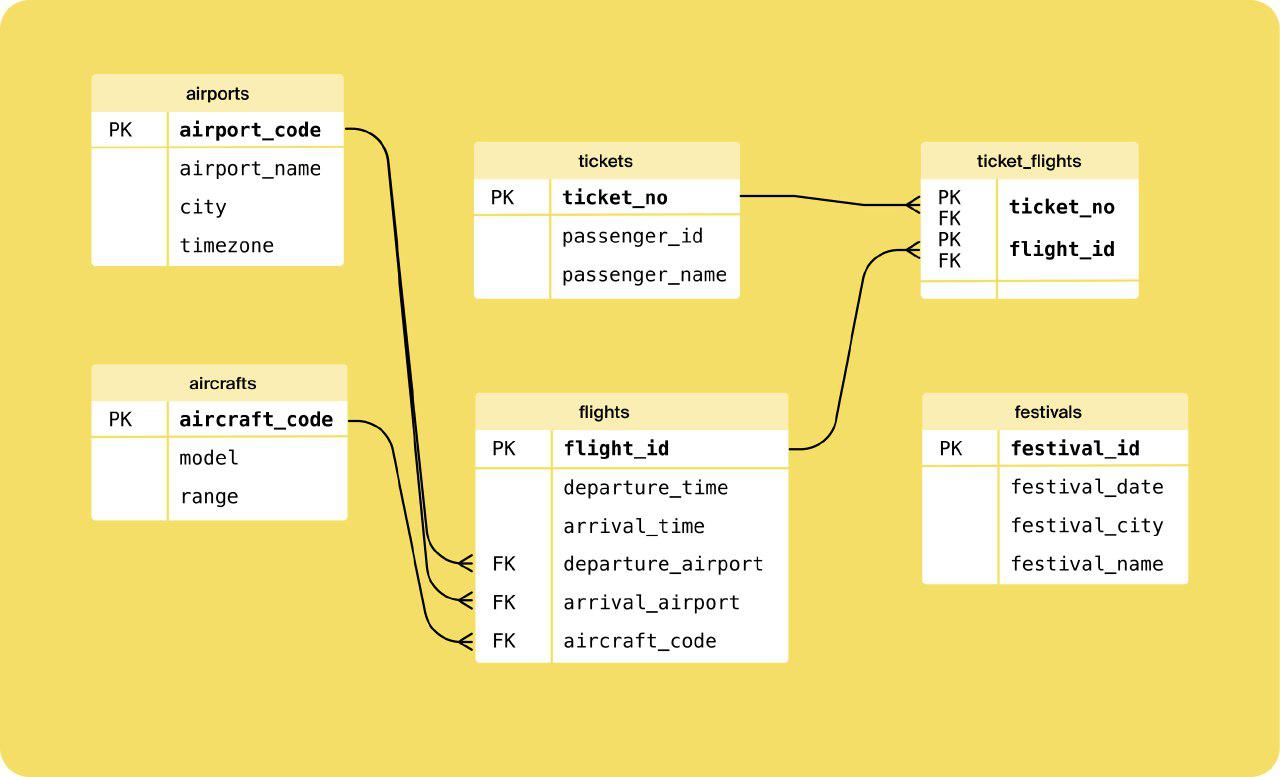

### Загрузка библиотек 

In [80]:
import pandas as pd
from IPython.display import display
import numpy as np

import matplotlib.pyplot as plt

import requests
from bs4 import BeautifulSoup

import warnings
warnings.filterwarnings('ignore')

# sql
from sqlalchemy import create_engine

## Парсинг данных

Задание: написать парсер для сбора с сайта данных о 11 крупнейших фестивалях 2018 года. Сохраните данные в датафрейм festivals и вывести на экран.

In [77]:
URL = 'https://.../festival_news/index.html'
req = requests.get(URL)

soup = BeautifulSoup(req.text, 'lxml')
table = soup.find('table', attrs={'id':'best_festivals'})
heading_table = []
for row in table.find_all('th'):
    heading_table.append(row.text)

content=[]
for row in table.find_all('tr'):
    if not row.find_all('th'):
        content.append([element.text for element in row.find_all('td')])
        

festivals = pd.DataFrame(content, columns=heading_table)

In [78]:
festivals.sample(5)

,Название фестиваля,Место проведения,Дата проведения
10,«Нашествие 2018»,Тверь,05.08.2018
1,Фестиваль музыки и технологий Alfa Future People,Нижний Новгород,10.08.2018
4,Park Live,Москва,28.07.2018
8,"Фестиваль «О, да! Еда!»",Владивосток,02.09.2018
0,Музыкальный фестиваль «Усадьба Jazz»,Екатеринбург,01.07.2018


## SQL

**Задание № 1**

Изучите таблицу `flights` и подсчитайте количество вылетов (`flight_id`) из каждого аэропорта вылета (`departure_airport`). Назовите переменную `cnt_flights` и выведите её вместе со столбцом `departure_airport` — сначала `departure_airport`, потом `cnt_flights`. Результат отсортируйте в порядке убывания количества вылетов.

In [ ]:
SELECT
    departure_airport,
    count(flight_id) as cnt_flights
FROM flights
GROUP BY departure_airport
ORDER BY cnt_flights DESC

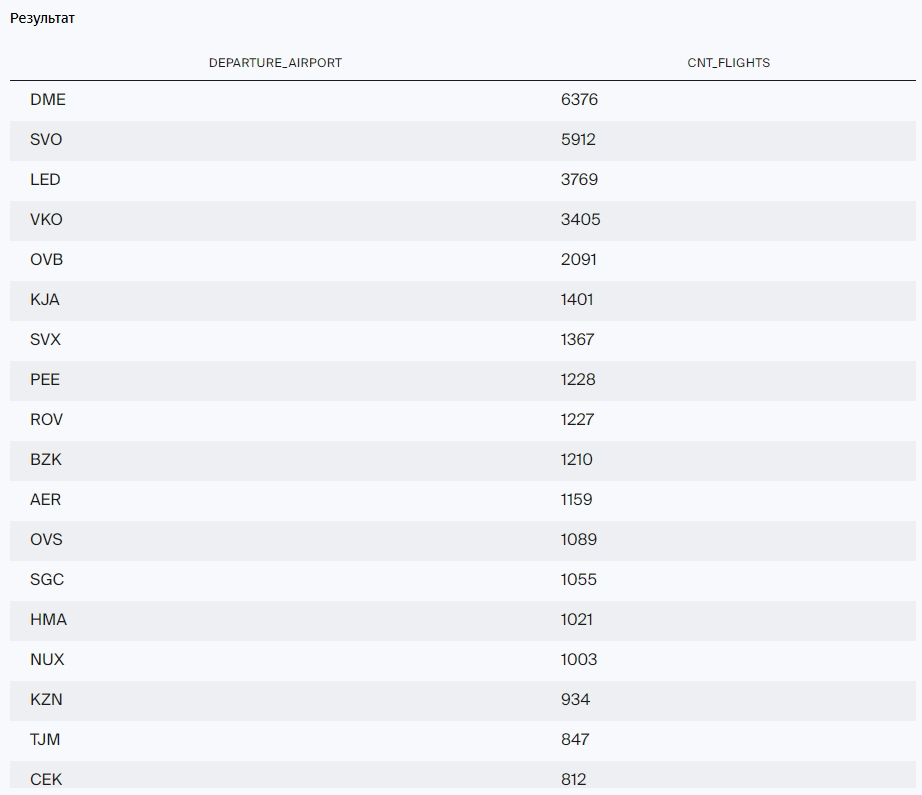

**Задание № 2**

Найдите количество рейсов на каждой модели самолёта с вылетом в сентябре 2018 года. Назовите получившийся столбец `flights_amount` и выведите его, также выведите столбец `model`.
Столбцы выводите в таком порядке:
- model
- flights_amount

In [ ]:
SELECT
    aircrafts.model AS model,
    count(flights.flight_id) AS flights_amount
FROM 
    flights
    LEFT JOIN aircrafts ON aircrafts.aircraft_code = flights.aircraft_code
WHERE
    flights.departure_time :: date BETWEEN '2018-09-01' AND '2018-09-30'
GROUP BY 
    model

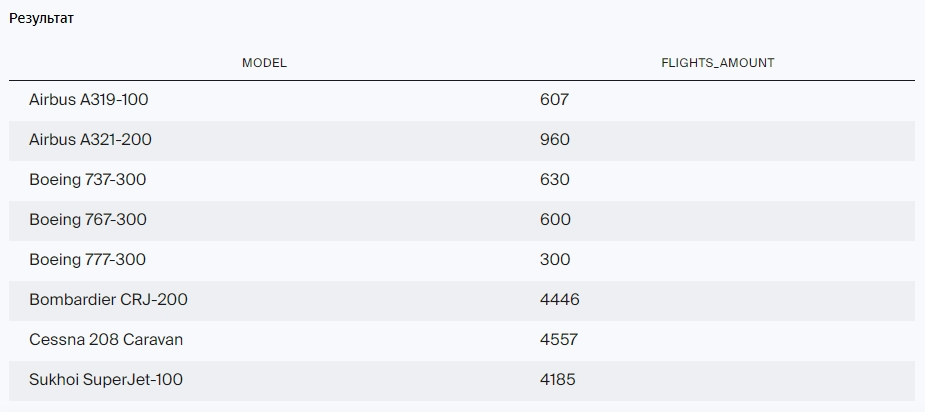

**Задание № 3**

Посчитайте количество рейсов по всем моделям самолётов Boeing, Airbus и другим ('other') в сентябре. Типы моделей поместите в столбец `type_aircraft`, а количество рейсов — во `flights_amount`. Выведите их на экран.

In [ ]:
SELECT
    (CASE WHEN aircrafts.model LIKE '%Boeing%' THEN
        'Boeing'
    WHEN aircrafts.model LIKE '%Airbus%' THEN
        'Airbus'
    ELSE 'other'
    END) AS type_aircraft,
    count(flights.flight_id) AS flights_amount
FROM 
    flights
    INNER JOIN aircrafts ON aircrafts.aircraft_code = flights.aircraft_code
WHERE
    flights.departure_time :: date BETWEEN '2018-09-01' AND '2018-09-30'
GROUP BY 
    type_aircraft

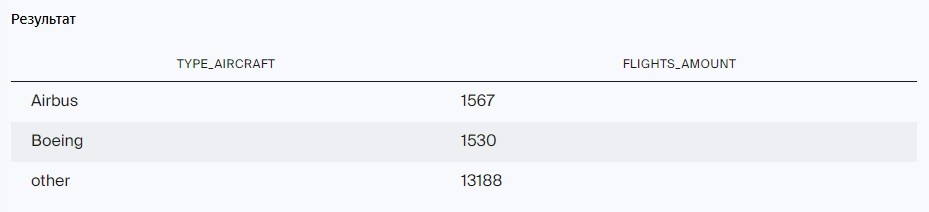

**Задание № 4**

Посчитайте среднее количество прибывающих рейсов в день для каждого города за август 2018 года. Назовите получившееся поле `average_flights`, вместе с ним выведите столбец `city`.
Выводите столбцы в таком порядке:
- `city`,
- `average_flights`.

In [ ]:
SELECT 
    subq.city as city,
    AVG(subq.count_flight) AS average_flights
FROM (
    SELECT 
        airports.city AS city, 
        COUNT(flights.flight_id) AS count_flight,
        EXTRACT(day from flights.arrival_time) AS day_number
    FROM flights
    INNER JOIN airports ON airports.airport_code = flights.arrival_airport
    WHERE arrival_time :: date BETWEEN '2018-08-01' AND '2018-08-31'
    GROUP BY city, day_number
    ) AS subq
GROUP BY city

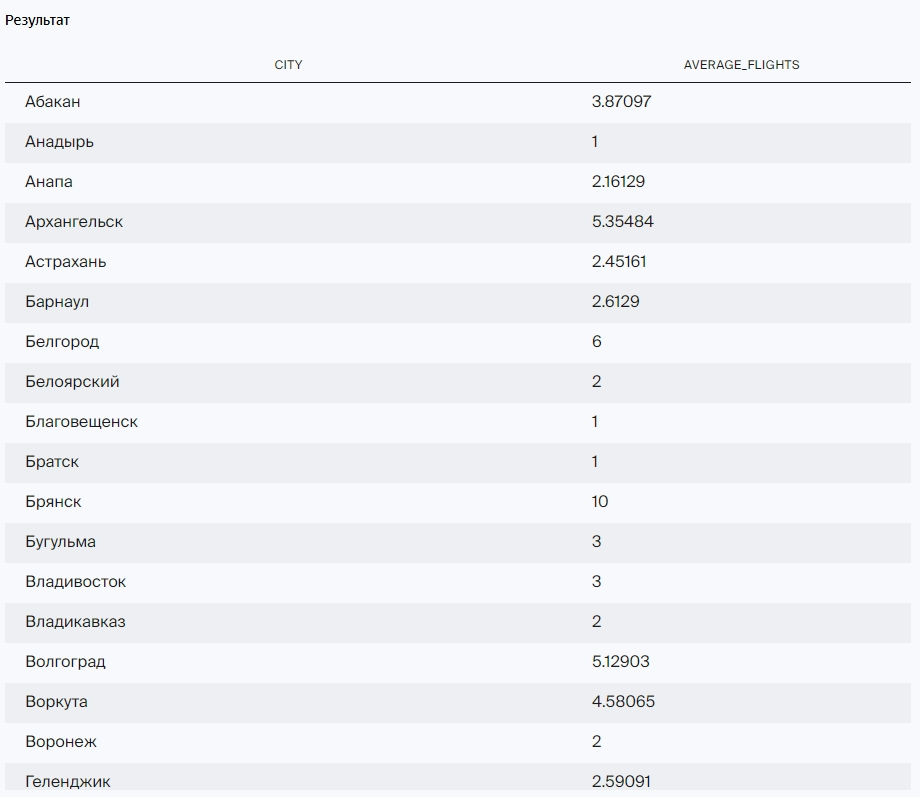

**Задание № 5**

Установите фестивали, которые проходили с 23 июля по 30 сентября 2018 года в Москве, и номер недели, в которую они проходили. Выведите название фестиваля `festival_name` и номер недели `festival_week`.

In [ ]:
SELECT
    festival_name,
    EXTRACT (week FROM festival_date :: date) AS festival_week
FROM
    festivals
WHERE
    festival_date :: date BETWEEN '2018-06-23' AND '2018-09-30'
    AND festival_city = 'Москва'

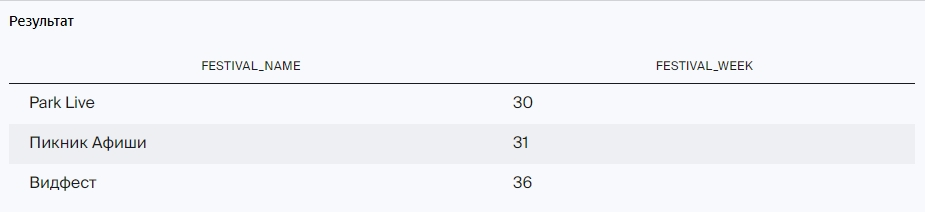

**Задание № 6**

Для каждой недели с 23 июля по 30 сентября 2018 года посчитайте количество билетов, купленных на рейсы в Москву (номер недели `week_number` и количество билетов `ticket_amount`). Получите таблицу, в которой будет номер недели; информация о количестве купленных за неделю билетов; номер недели ещё раз, если в эту неделю проходил фестиваль, и nan, если не проходил; а также название фестиваля `festival_name`.
Выводите столбцы в таком порядке:
- `week_number`,
- `ticket_amount`,
- `festival_week`,
- `festival_name`.

In [ ]:
SELECT
    SUBQ_1.week_number AS week_number,
    SUBQ_1.ticket_amount AS ticket_amount,
    SUBQ_2.festival_week AS festival_week,
    SUBQ_2.festival_name AS festival_name
FROM
(SELECT
    EXTRACT (week FROM flights.arrival_time :: date) AS week_number,
    COUNT(ticket_flights.ticket_no) AS ticket_amount
FROM
    flights
    INNER JOIN ticket_flights ON ticket_flights.flight_id = flights.flight_id
    INNER JOIN airports ON airports.airport_code = flights.arrival_airport
WHERE
    flights.arrival_time :: date BETWEEN '2018-07-23' AND '2018-09-30' 
    AND airports.city = 'Москва'
GROUP BY
    week_number
ORDER BY 
    week_number asc) AS SUBQ_1

LEFT JOIN 

(SELECT
    EXTRACT (week FROM festival_date :: date) AS festival_week,
    festival_name
FROM
    festivals
WHERE
    festival_date :: date BETWEEN '2018-07-23' AND '2018-09-30'
    AND festival_city = 'Москва') AS SUBQ_2 ON SUBQ_2.festival_week = SUBQ_1.week_number


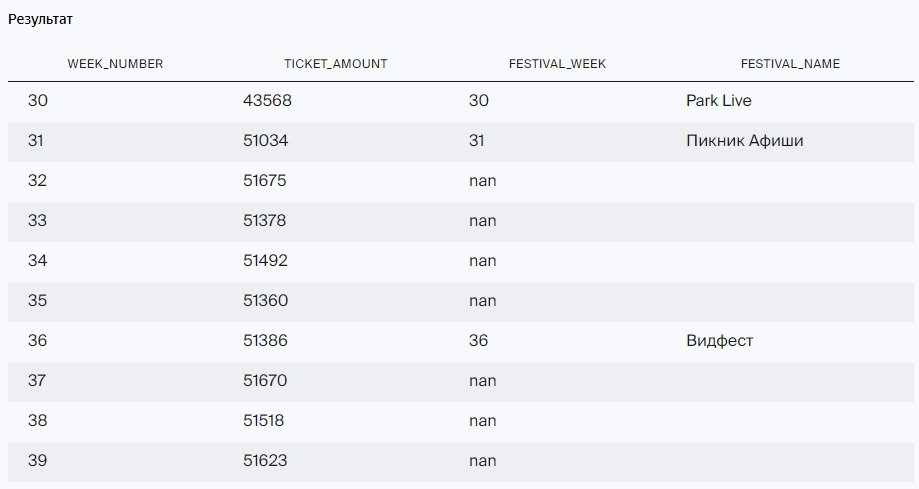

Финальная таблица получилась совсем небольшая, проверять по ней гипотезу о связи музыкальных фестивалей и спроса не авиабилеты будет некорректно. Можно предположить, что во время фестивалей спрос практически не меняется: достаточно посмотреть на стоимость билетов и мысленно сравнить значения.

## Аналитика средствами Python

### Описание данные

**Таблица model**:

- model — модели самолета
- flights_amount — количество рейсов для каждой модели самолетов model в сентябре 2018 года


**Таблица city**:
- city — городах
- average_flights — среднем количестве рейсов, прибывающих в город city за день в августе 2018 года

### Загрузка данных

In [2]:
model = pd.read_csv('https://.../query_1.csv')
city = pd.read_csv('https://.../query_3.csv')

### Изучение таблицы model

In [3]:
model.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8 entries, 0 to 7
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   model           8 non-null      object
 1   flights_amount  8 non-null      int64 
dtypes: int64(1), object(1)
memory usage: 256.0+ bytes


In [4]:
display(model)

,model,flights_amount
0,Airbus A319-100,607
1,Airbus A321-200,960
2,Boeing 737-300,630
3,Boeing 767-300,600
4,Boeing 777-300,300
5,Bombardier CRJ-200,4446
6,Cessna 208 Caravan,4557
7,Sukhoi SuperJet-100,4185


In [5]:
model.describe()

,flights_amount
count,8.000000
mean,2035.625000
std,1965.203947
min,300.000000
25%,605.250000
50%,795.000000
75%,4250.250000
max,4557.000000


Таблица не содержит пропусков, типы данных имеют подходящий формат.

### Изучение таблицы city

In [6]:
city.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101 entries, 0 to 100
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   city             101 non-null    object 
 1   average_flights  101 non-null    float64
dtypes: float64(1), object(1)
memory usage: 1.7+ KB


In [7]:
city.sample(5, random_state=42)

,city,average_flights
84,Ульяновск,9.580645
55,Новый Уренгой,8.290323
66,Псков,1.548387
67,Ростов-на-Дону,10.193548
45,Надым,2.290323


In [8]:
city.describe()

,average_flights
count,101.000000
mean,5.494189
std,13.119790
min,1.000000
25%,2.000000
50%,3.000000
75%,5.870968
max,129.774194


Таблица не содержит пропусков, типы данных в принципе подходящие, можно округлить данные о среднем количестве рейсов до целых, т.к. это несколько укрупнит наши данные, что поможет нам построить более читаемые графики, в то же время в текущем случае разница в десятые в среднем количестве рейсов не имеет критичной значимости.

In [9]:
city['average_flights'] = city['average_flights'].astype(int)

## Анализ

### топ-10 городов по количеству рейсов

In [10]:
top10 = city.sort_values('average_flights', ascending=False).reset_index().loc[0:9]

In [11]:
top10

,index,city,average_flights
0,43,Москва,129
1,70,Санкт-Петербург,31
2,54,Новосибирск,17
3,20,Екатеринбург,11
4,33,Красноярск,11
5,63,Пермь,10
6,67,Ростов-на-Дону,10
7,10,Брянск,10
8,84,Ульяновск,9
9,73,Советский,9


In [12]:
def plotting(df, y, x, title, xlabel, ylabel, figsize, legend):
    df.plot.barh(y=y, x=x, grid=True, figsize=figsize, legend=legend)
    plt.title(title)
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)
    plt.show()

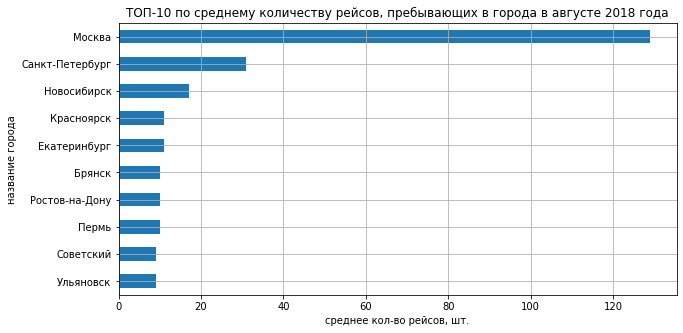

In [13]:
plotting(df = top10.sort_values('average_flights', ascending=True), 
         y='average_flights', 
         x='city', 
         title = 'ТОП-10 по среднему количеству рейсов, пребывающих в города в августе 2018 года', 
         xlabel = 'среднее кол-во рейсов, шт.' , 
         ylabel = 'название города', 
         figsize=(10,5),
         legend = False
        )

Ожидаемо лидируют Москва и Санкт-Петербург - города федерального значения, к тому же располагающиеся в самой густонаселенной европейской части страны. 

Далее, опять же ожидаемо, идут наиболее крупные города Сибири и Урала - Новосибирск, Красноярск и Екатеринбург. В связи с удаленностью от центральной части они являются центрами деловой, торговой, транспортной жизни Сибири и Урала, а соответственно, и главными транспортными узлами. 

Примечательно, что в ТОП-10 попал небольшой город Советский. Объяснить это можно тем, что в Советском функционирует аэропорт, основным родом деятельности которого является вертолетное сообщение с северными посёлками, не имеющими автомобильной дороги.

### модели самолетов и количество рейсов

Немного "обогатим" наши данные, добавив информацию о пассажировместимости моделей (т.к. найти отдельную таблицу по всем моделям не удалось, а моделей всего 8 шт., быстрее будет добавить "руками", данные взяты с сайта http://wikiredia.ru из статей по каждой модели самолета отдельно).

In [14]:
model['min_passenger_capacity'] = ['116', '170','128', '218', '368', '50', '9', '98']
model['max_passenger_capacity'] = ['156', '220','149', '350', '451', '50', '13', '98']

In [15]:
model['min_passenger_capacity'] = model['min_passenger_capacity'].astype(int)
model['max_passenger_capacity'] = model['max_passenger_capacity'].astype(int)

In [16]:
model['avg_passenger_capacity'] = ((model['min_passenger_capacity'] + model['max_passenger_capacity']) / 2).astype(int)
model['passenger_traffic_ths'] = (model['flights_amount'] * model['avg_passenger_capacity'])/1000

In [17]:
model.sort_values('flights_amount', ascending=False)

,model,flights_amount,min_passenger_capacity,max_passenger_capacity,avg_passenger_capacity,passenger_traffic_ths
6,Cessna 208 Caravan,4557,9,13,11,50.127
5,Bombardier CRJ-200,4446,50,50,50,222.300
7,Sukhoi SuperJet-100,4185,98,98,98,410.130
1,Airbus A321-200,960,170,220,195,187.200
2,Boeing 737-300,630,128,149,138,86.940
0,Airbus A319-100,607,116,156,136,82.552
3,Boeing 767-300,600,218,350,284,170.400
4,Boeing 777-300,300,368,451,409,122.700


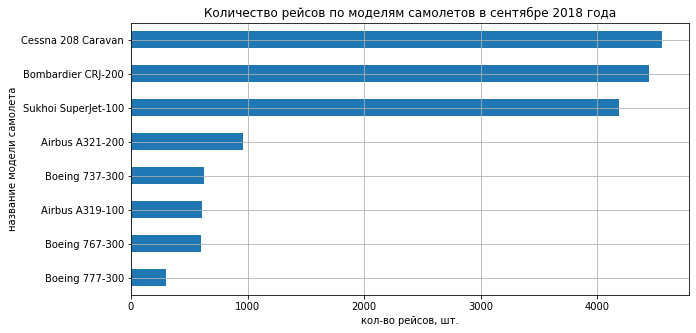

In [18]:
plotting(df = model.sort_values('flights_amount', ascending=True), 
         y = 'flights_amount', 
         x = 'model', 
         title = 'Количество рейсов по моделям самолетов в сентябре 2018 года', 
         xlabel = 'кол-во рейсов, шт.' , 
         ylabel = 'название модели самолета', 
         figsize=(10,5),
         legend = False
        )

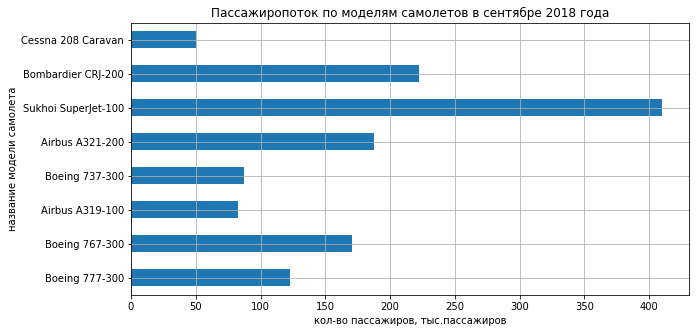

In [19]:
plotting(df = model.sort_values('flights_amount', ascending=True), 
         y = 'passenger_traffic_ths', 
         x = 'model', 
         title = 'Пассажиропоток по моделям самолетов в сентябре 2018 года', 
         xlabel = 'кол-во пассажиров, тыс.пассажиров' , 
         ylabel = 'название модели самолета', 
         figsize=(10,5),
         legend = False
         )

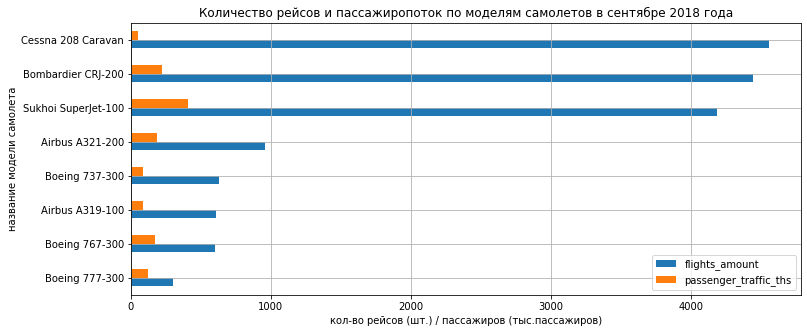

In [20]:
plotting(df = model.sort_values('flights_amount', ascending=True), 
         y = ['flights_amount', 'passenger_traffic_ths'], 
         x = 'model', 
         title = 'Количество рейсов и пассажиропоток по моделям самолетов в сентябре 2018 года', 
         xlabel = 'кол-во рейсов (шт.) / пассажиров (тыс.пассажиров)' , 
         ylabel = 'название модели самолета', 
         figsize=(12,5),
         legend = True
        )

Лидируют модели самолетов с малой вместимостью, количество рейсов за сентябрь 2018 года по каждому из них составила более 4 000: 
- "Cessna 208 Caravan" может перевезти от 9 до 13 человек, используют такие самолеты для перевозок на небольшие расстояния,
- "Bombardier CRJ-200" перевозит до 50 человек и может использоваться для региональных перевозок,
- "Sukhoi SuperJet-100" вмещает 98 пассажиров и так же служит для перевозки между регионами. 

Цесна скорее всего используется для перелетов там, где или нет других видов сообщения (авто, ЖД) между субъектами или оно затруднено, например, в районах Крайнего Севера и т.п. Этим объясняется и высокая частота рейсов и малый пассажиропоток. 

И Бомбардир и Суперджет подходят для регулярных рейсов с небольшой дальностью перелетов по направлениям, на которые есть спрос, скорее всего, связанный с экономической деятельностью регионов и деловой активностью субъектов. Этим можно объяснить высокое количество рейсов за месяц. Для бизнеса важна возможность за короткий срок переместиться из одного города в другой в случае необходимости (проведение переговоров, встреч с партнерами, участие в форумах/выставках и т.п.). У данных моделей самый высокий пассажиропоток из исследуемых моделей.   

На самолетах бОльшей вместимости (около 150 - 250 человек) количество рейсов за сентябрь 2018 года меньше 1 000. 

Аэробусы А321-200, А319-100 и Боинг 737-300 (4 - 6 строки на графике) используются для перелетов ближней и средней протяженности. Можно сказать, что это аналоги Бомбардира и Суперджета, но для направлений с меньшим пассажиропотоком и спросом. Желающих меньше, поэтому приходится отправлять рейсы реже. 

Меньше всего рейсов для самолетов средней и дальней протяженности. Это модели Боинг 767 и 777. Рейсов хоть и мало, но за счет большой вместительности пассажиропоток не самый маленький. Такие модели целесообразны в использовании для перелетов между большими транспортными узлами, которыми как правило являются столицы государств или другие наиболее крупные города,соответственно, и спрос среди пассажиров на такие пункты прибытия высокий. 


### города и количество рейсов

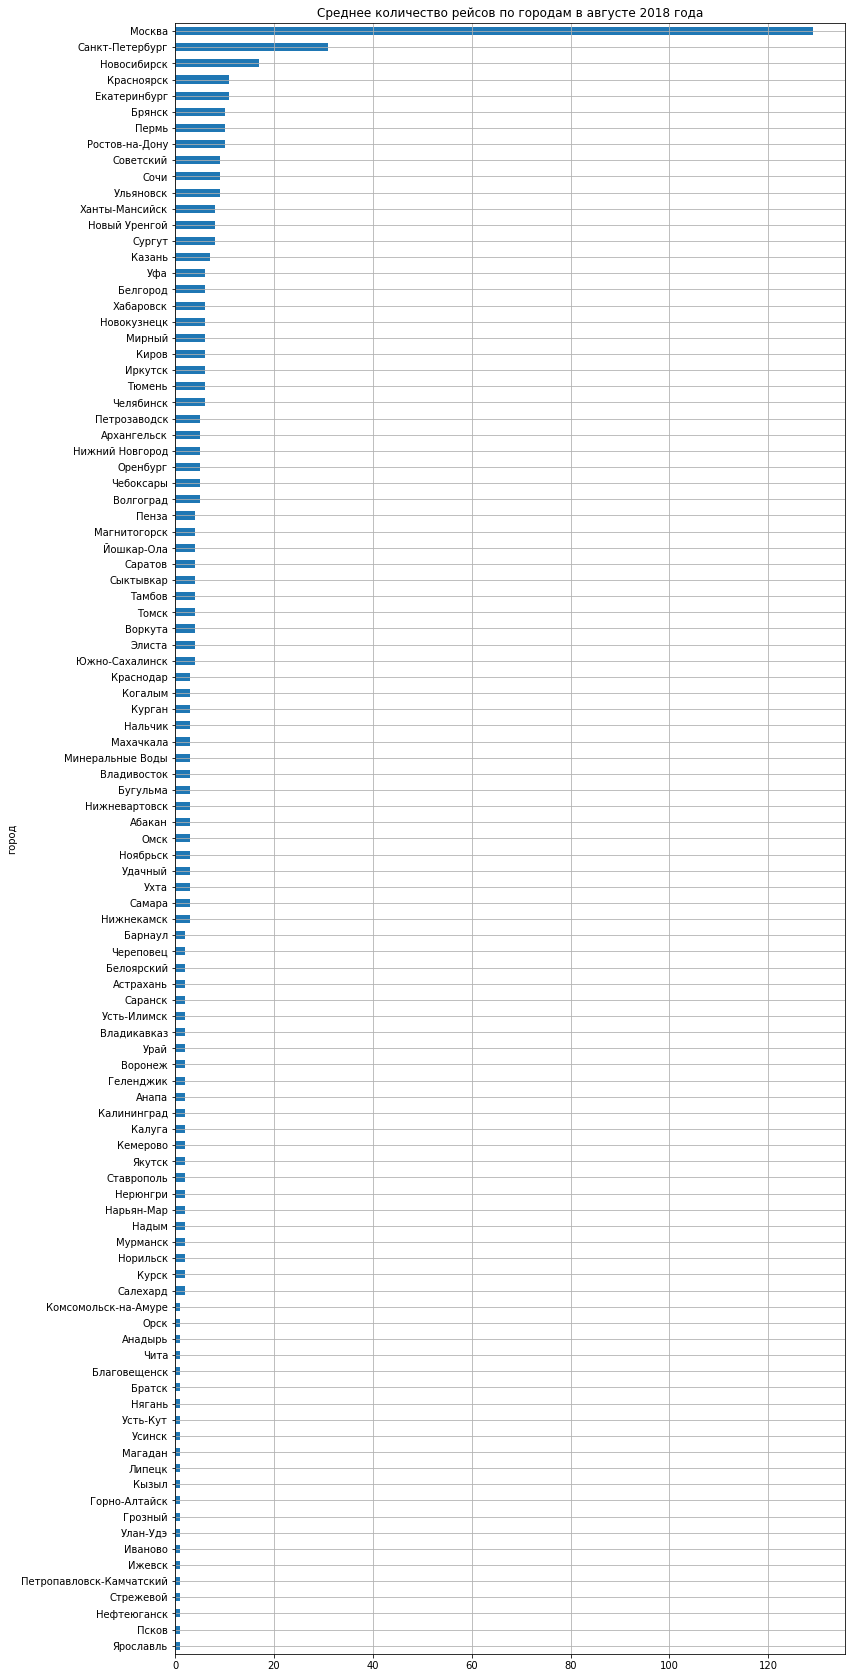

In [21]:
(city
 .sort_values('average_flights')
 .plot.barh(
     y ='average_flights', 
     x = 'city', 
     grid=True, 
     figsize=(12, 30), 
     legend = False)
)
plt.title('Среднее количество рейсов по городам в августе 2018 года')
plt.ylabel('город')
plt.show()

In [22]:
city.pivot_table(index='average_flights', values='city', aggfunc='count')

,city
average_flights,
1,22
2,23
3,16
4,10
5,6
6,9
7,1
8,3
9,3


По графику сложно сделать какие-то выводы, одинаковое среднее количество рейсов совершается как из крупных, так и из очень маленьких городов, например, Сочи и Советский. 
Много городов, из которых совершается в среднем по одному или 2 вылета, причем города эти расположены в разных частях России. 

С учетом того, что у нас есть данные только по 1ой (при этом вымышленной) авиакомпании "F9", однозначно можно сказать, что у нашей авиакомпании разнообразная и широкая география полетов. Можно сделать предположение, что в городах с малым количеством рейсов присутствует экспансия других авиакомпаний. 

Данных, конечно, маловато, но попробуем добавить к нашим данным информацию о населении городов и посмотрим есть ли взаимосвязь между размерами городов и количеством рейсов (заодно попрактикуемся в парсинге)).

#### парсинг данных по населению в городах России

Спарсим данные из Википедии.

##### данные по населению более 100 тыс. 

In [23]:
URL = 'https://ru.wikipedia.org/wiki/Список_городов_России_с_населением_более_100_тысяч_жителей'
req = requests.get(URL)

In [24]:
req.status_code

200

In [25]:
soup = BeautifulSoup(req.text, 'lxml')
table = soup.find('table')

In [26]:
#список из названий столбцов
heading_table = []
for row in table.find_all('th'):
    heading_table.append(row.text)
    
print(heading_table)

['№', 'Город', 'Население, тыс. человек\n', '', 'в1897[17]', '1897', '1926', '1939', '1959', '1970', '1979', '1989', '2002', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019', '2020', '2021\n']


In [27]:
#данные для тела таблицы
content=[]
for row in table.find_all('tr'):
    if not row.find_all('th'):
        content.append([element.text for element in row.find_all('td')])
        
print(content)

[['1\n', '2', 'Москва[18]', '1039', '2080', '4609', '6133', '7194', '8057', '8878', '10126', '11504', '11541', '11613', '11980', '12108', '12198', '12330', '12381', '12506', '12615', '12678', '12655\n'], ['2\n', '1', 'Санкт-Петербург', '1265', '1737', '3431', '3390', '4033', '4569', '4989', '4661', '4880', '4899', '4953', '5028', '5132', '5192', '5226', '5282', '5352', '5384', '5398', '5384\n'], ['3\n', '', 'Новосибирск', '8', '120', '404', '885', '1161', '1309', '1420', '1426', '1474', '1475', '1499', '1524', '1548', '1567', '1584', '1603', '1613', '1618', '1626', '1620\n'], ['4\n', '35', 'Екатеринбург', '43', '140', '423', '779', '1025', '1210', '1296', '1294', '1350', '1353', '1378', '1396', '1412', '1428', '1444', '1456', '1469', '1483', '1494', '1495\n'], ['5\n', '4', 'Казань', '130', '179', '406', '667', '869', '989', '1085', '1105', '1144', '1145', '1161', '1176', '1191', '1206', '1217', '1232', '1244', '1252', '1257', '1257\n'], ['6\n', '8', 'Нижний Новгород', '90', '222', '644

In [28]:
#удалим "лишние" столбцы из списка 
heading_table = ['№', 'в1897', 'Город', '1897', '1926', '1939', '1959', '1970', '1979', '1989', '2002', '2010', 
                 '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019', '2020', '2021\n']

In [29]:
population = pd.DataFrame(content, columns=heading_table)

In [30]:
population

,№,в1897,Город,1897,1926,1939,1959,1970,1979,1989,...,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021\n
0,1\n,2,Москва[18],1039,2080,4609,6133,7194,8057,8878,...,11613,11980,12108,12198,12330,12381,12506,12615,12678,12655\n
1,2\n,1,Санкт-Петербург,1265,1737,3431,3390,4033,4569,4989,...,4953,5028,5132,5192,5226,5282,5352,5384,5398,5384\n
2,3\n,,Новосибирск,8,120,404,885,1161,1309,1420,...,1499,1524,1548,1567,1584,1603,1613,1618,1626,1620\n
3,4\n,35,Екатеринбург,43,140,423,779,1025,1210,1296,...,1378,1396,1412,1428,1444,1456,1469,1483,1494,1495\n
4,5\n,4,Казань,130,179,406,667,869,989,1085,...,1161,1176,1191,1206,1217,1232,1244,1252,1257,1257\n
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
166,167\n,,Ханты-Мансийск,—,—,7,21,25,28,34,...,85,91,93,95,97,99,98,99,101,103\n
167,168\n,136,Ногинск,11,39,81,95,104,119,123,...,102,102,102,102,102,102,103,102,104,103\n
168,169\n,30,Елец,47,43,51,78,101,111,120,...,108,107,106,106,105,105,104,103,102,101\n
169,170\n,,Железногорск,—,—,—,—,31,65,85,...,96,97,98,99,100,101,101,100,100,101\n


Удалим информацию за года, которые нам не интересны, оставим только названия городов и население за 2018 год

In [31]:
population.drop(['№', 'в1897', '1897', '1926', '1939', '1959', '1970', '1979', '1989', '2002', '2010', 
                 '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2019', '2020', '2021\n'], axis=1, inplace=True)

In [32]:
#переименуем названия столбцов
population.set_axis(['city', 'population_2018_ths'], axis='columns', inplace=True)

In [33]:
#в названиях некоторых городов встречаются символы типа [17], которые были сносками на сайте, удалим их из названий 
population['city'] = population['city'].replace(regex=True, to_replace=r'[^А-я -]', value='')

In [34]:
#заменим тип данных на числовой 
population['population_2018_ths'] = population['population_2018_ths'].astype(int)

In [35]:
population.head()

,city,population_2018_ths
0,Москва,12506
1,Санкт-Петербург,5352
2,Новосибирск,1613
3,Екатеринбург,1469
4,Казань,1244


In [36]:
population.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 171 entries, 0 to 170
Data columns (total 2 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   city                 171 non-null    object
 1   population_2018_ths  171 non-null    int32 
dtypes: int32(1), object(1)
memory usage: 2.1+ KB


##### данные по населению до 100 тыс. 

Проведем аналогичные манипуляции по парсингу для городов с населением менее 100 тыс. 

In [37]:
URL_2 = 'https://ru.wikipedia.org/wiki/Города_России'
req_2 = requests.get(URL_2)

In [38]:
req_2.status_code

200

In [39]:
soup = BeautifulSoup(req_2.text, 'lxml')

table_50_100 = soup.findAll('table')[13]

table_50 = soup.findAll('table')[14]

In [40]:
#список из названий столбцов, один для 2х таблиц, т.к. заголовки у них аналогичны
heading_table = []
for row in table_50_100.find_all('th'):
    heading_table.append(row.text)
    
print(heading_table)

['Список средних городов', '№', 'Город', 'Субъект РФ', '2021', '2020', '2019', '2018', '2017', '2016', '2015', '2014', '2013', '2012', '2011', '2010']


In [41]:
#данные для тела таблиц
content_50_100=[]
for row in table_50_100.find_all('tr'):
    if not row.find_all('th'):
        content_50_100.append([element.text for element in row.find_all('td')])
for row in table_50.find_all('tr'):
    if not row.find_all('th'):
        content_50_100.append([element.text for element in row.find_all('td')])

In [43]:
#удалим "лишние" столбцы из списка, появившиеся из-за мультииндекса в таблице на сайте
heading_table = ['№', 'Город', 'Субъект РФ', '2021', '2020', '2019', '2018', '2017', 
                 '2016', '2015', '2014', '2013', '2012', '2011', '2010']

In [44]:
population_100 = pd.DataFrame(content_50_100, columns=heading_table)

In [45]:
population_100

,№,Город,Субъект РФ,2021,2020,2019,2018,2017,2016,2015,2014,2013,2012,2011,2010
0,1,Новокуйбышевск,Самарская область,99 469,100 455,100 940,102 075,102 933,103 908,105 007,106 023,106 883,107 592,108 400,108 438\n
1,2,Сергиев Посад,Московская область,98 784,100 335,101 967,103 444,104 579,104 994,106 007,106 718,108 490,109 656,110 900,111 179\n
2,3,Тобольск,Тюменская область,98 772,98 932,98 857,98 998,98 886,98 434,98 162,98 052,98 169,98 287,99 700,99 694\n
3,4,Воткинск,Удмуртия,96 861,97 244,97 345,97 550,98 063,98 134,98 222,98 045,98 287,98 628,99 000,99 022\n
4,5,Саров,Нижегородская область,96 479,96 052,95 469,95 388,95 065,94 417,94 417,94 080,93 428,92 996,,92 047\n
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
939,790,Курильск,Сахалинская область,1 519,1 591,1 607,1 547,1 646,1 670,1 757,1 890,1 961,2 062,2 070\n,None
940,791,Высоцк,Ленинградская область,1 089,1 094,1 115,1 120,1 131,1 152,1 155,1 183,1 214,1 238,1 244\n,None
941,792,Верхоянск,Якутия,1 073,1 095,1 122,1 131,1 125,1 150,1 173,1 212,1 245,1 300,1 311\n,None
942,793,Чекалин,Тульская область,863,888,914,941,965,964,975,985,979,1 000,994\n,None


In [46]:
population_100.drop(['№', 'Субъект РФ', '2021', '2020', '2019', '2017', 
                 '2016', '2015', '2014', '2013', '2012', '2011', '2010'], axis=1, inplace=True)

In [47]:
population_100.head()

,Город,2018
0,Новокуйбышевск,102 075
1,Сергиев Посад,103 444
2,Тобольск,98 998
3,Воткинск,97 550
4,Саров,95 388


In [48]:
population_100['Город'].unique()

array([' Новокуйбышевск ', ' Сергиев Посад ', ' Тобольск ', ' Воткинск ',
       ' Саров ', ' Междуреченск ', ' Михайловск ', ' Серов ',
       ' Сарапул ', ' Анапа ', ' Ленинск-Кузнецкий ', ' Ухта ',
       ' Воскресенск ', ' Соликамск ', ' Глазов ', ' Магадан ',
       ' Великие Луки ', ' Мичуринск ', ' Лобня ', ' Гатчина ', ' Канск ',
       ' Каменск-Шахтинский ', ' Губкин ', ' Бузулук ', ' Киселёвск ',
       ' Ейск ', ' Ивантеевка ', ' Новотроицк ', ' Чайковский ',
       ' Бугульма ', ' Железногорск ', ' Юрга ', ' Кинешма ', ' Азов ',
       ' Кузнецк ', ' Усть-Илимск ', ' Новоуральск ', ' Клин ',
       ' Видное ', ' Мурино ', ' Ялта ', ' Озёрск ', ' Кропоткин ',
       ' Бор ', ' Всеволожск ', ' Геленджик ', ' Черногорск ',
       ' Усолье-Сибирское ', ' Балашов ', ' Новоалтайск ', ' Дубна ',
       ' Шадринск ', ' Верхняя Пышма ', ' Выборг ', ' Елабуга ',
       ' Минеральные Воды ', ' Егорьевск ', ' Троицк ', ' Чехов ',
       ' Чапаевск ', ' Белово ', ' Биробиджан ', ' Кога

В названиях городов есть пробелы в начале и конце строк, также пробел разделяет тысячи в столбце с данными о населении. Уберем пробелы: 

In [49]:
#удалим пробелы в названиях городов и между цифрами в данных о населении
population_100['Город'] = population_100['Город'].str.strip()

population_100['2018'] = population_100['2018'].replace(regex=True, to_replace=r'[ ]', value='')

In [50]:
population_100['Город'].unique()

array(['Новокуйбышевск', 'Сергиев Посад', 'Тобольск', 'Воткинск', 'Саров',
       'Междуреченск', 'Михайловск', 'Серов', 'Сарапул', 'Анапа',
       'Ленинск-Кузнецкий', 'Ухта', 'Воскресенск', 'Соликамск', 'Глазов',
       'Магадан', 'Великие Луки', 'Мичуринск', 'Лобня', 'Гатчина',
       'Канск', 'Каменск-Шахтинский', 'Губкин', 'Бузулук', 'Киселёвск',
       'Ейск', 'Ивантеевка', 'Новотроицк', 'Чайковский', 'Бугульма',
       'Железногорск', 'Юрга', 'Кинешма', 'Азов', 'Кузнецк',
       'Усть-Илимск', 'Новоуральск', 'Клин', 'Видное', 'Мурино', 'Ялта',
       'Озёрск', 'Кропоткин', 'Бор', 'Всеволожск', 'Геленджик',
       'Черногорск', 'Усолье-Сибирское', 'Балашов', 'Новоалтайск',
       'Дубна', 'Шадринск', 'Верхняя Пышма', 'Выборг', 'Елабуга',
       'Минеральные Воды', 'Егорьевск', 'Троицк', 'Чехов', 'Чапаевск',
       'Белово', 'Биробиджан', 'Когалым', 'Кирово-Чепецк', 'Дмитров',
       'Туймазы', 'Славянск-на-Кубани', 'Феодосия', 'Минусинск',
       'Сосновый Бор', 'Наро-Фоминск', '

In [51]:
population_100.head()

,Город,2018
0,Новокуйбышевск,102075
1,Сергиев Посад,103444
2,Тобольск,98998
3,Воткинск,97550
4,Саров,95388


In [52]:
population_100.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 944 entries, 0 to 943
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Город   944 non-null    object
 1   2018    944 non-null    object
dtypes: object(2)
memory usage: 14.9+ KB


Теперь приведем тип данных в столбце с населением к числовому и переведем в тысячи:

In [53]:
#заменим тип данных на числовой и переведем в тысячи
population_100['2018'] = pd.to_numeric(population_100['2018'], errors='raise')

population_100['2018'] = (population_100['2018']/1000).round(0)

In [54]:
#переименуем названия столбцов
population_100.set_axis(['city', 'population_2018_ths'], axis='columns', inplace=True)

In [55]:
population_100.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 944 entries, 0 to 943
Data columns (total 2 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   city                 944 non-null    object 
 1   population_2018_ths  943 non-null    float64
dtypes: float64(1), object(1)
memory usage: 14.9+ KB


In [56]:
population_100.query('population_2018_ths.isna()')

,city,population_2018_ths
39,Мурино,NaN


Есть 2 строки с пропусками. Удалим их. 

In [57]:
population_100.dropna(subset=['population_2018_ths'], inplace=True)

In [58]:
population_100.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 943 entries, 0 to 943
Data columns (total 2 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   city                 943 non-null    object 
 1   population_2018_ths  943 non-null    float64
dtypes: float64(1), object(1)
memory usage: 22.1+ KB


Соединим данные по населению свыше 100 тыс. и до 100 тыс. в одну общую таблицу: 

In [59]:
population_all = pd.concat([population, population_100], ignore_index=True)

In [60]:
population_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1114 entries, 0 to 1113
Data columns (total 2 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   city                 1114 non-null   object 
 1   population_2018_ths  1114 non-null   float64
dtypes: float64(1), object(1)
memory usage: 17.5+ KB


In [61]:
population_all.sample(5, random_state=42)

,city,population_2018_ths
879,Горнозаводск,11.0
101,Балаково,190.0
1111,Верхоянск,1.0
726,Туринск,17.0
291,Ржев,59.0


#### добавление данных о численности

Добавим информацию о численности к нашей таблице с прилетами:

In [62]:
city = city.merge(population_all, on='city', how='left')

In [63]:
city.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 104 entries, 0 to 103
Data columns (total 3 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   city                 104 non-null    object 
 1   average_flights      104 non-null    int32  
 2   population_2018_ths  104 non-null    float64
dtypes: float64(1), int32(1), object(1)
memory usage: 2.8+ KB


In [64]:
city.head()

,city,average_flights,population_2018_ths
0,Абакан,3,184.0
1,Анадырь,1,15.0
2,Анапа,2,76.0
3,Архангельск,5,350.0
4,Астрахань,2,534.0


#### взаимосвязь размера города и количества рейсов

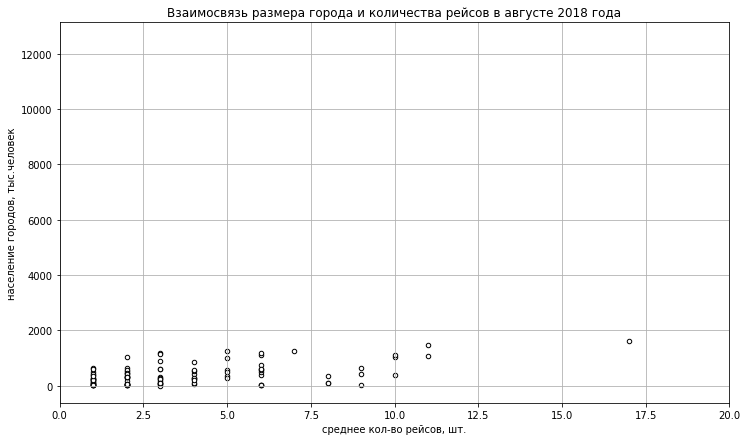

In [65]:
city.plot(x='average_flights', y='population_2018_ths', kind='scatter', figsize=(12, 7), 
            color='white', ec='black', grid=True, xlim=(0,20), 
          title='Взаимосвязь размера города и количества рейсов в августе 2018 года')
plt.xlabel('среднее кол-во рейсов, шт.')
plt.ylabel('население городов, тыс.человек')
plt.show()

В принципе ожидаемый разультат =) 



#### категоризация по величине городов

Крупнейшие —  с населением свыше 1 млн чел.

Крупные от 500 тыс. до 1 млн. 

Крупные от 250 тыс. до 500 тыс.  

Большие —  от 100 до 250 тыс. чел.

Средние —  от 50 до 100 тыс. чел.

Малые —  до 50 тыс. чел. 

In [66]:
def city_group(population_2018_ths):
    if population_2018_ths >= 1000:
        return 'крупнейшие'
    if 500 <= population_2018_ths < 1000:
        return 'крупные от 500 тыс. до 1 млн.'
    if 250 <= population_2018_ths < 500:
        return 'крупные от 250 тыс. до 500 тыс.'
    if 100 <= population_2018_ths < 250:
        return 'большие'
    if 50 <= population_2018_ths < 100:
        return 'средние'
    if population_2018_ths < 50:
        return 'малые'
    else: 
        print('ошибка')

In [67]:
city['city_group'] = city['population_2018_ths'].apply(city_group)

In [68]:
city.head()

,city,average_flights,population_2018_ths,city_group
0,Абакан,3,184.0,большие
1,Анадырь,1,15.0,малые
2,Анапа,2,76.0,средние
3,Архангельск,5,350.0,крупные от 250 тыс. до 500 тыс.
4,Астрахань,2,534.0,крупные от 500 тыс. до 1 млн.


Уберем из данных Москву и Питер, т.к. для наших целей они будут являться выбросами и посмотрим на размеры групп. 

In [69]:
city_without_cap = city.query('city != "Москва" & city != "Санкт-Петербург"')

In [70]:
(city_without_cap.pivot_table(index='city_group', values='average_flights', aggfunc=['mean', 'count']))

,mean,count
,average_flights,average_flights
city_group,,
большие,2.470588,17
крупнейшие,7.384615,13
крупные от 250 тыс. до 500 тыс.,3.520000,25
крупные от 500 тыс. до 1 млн.,3.894737,19
малые,3.000000,15
средние,2.692308,13


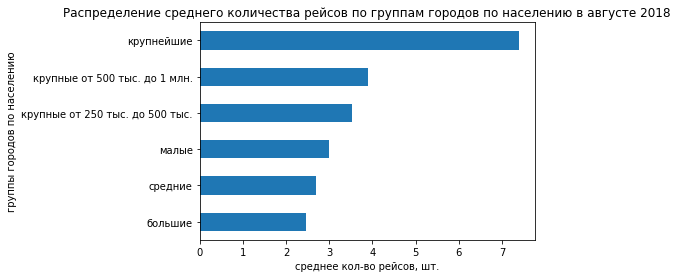

In [71]:
(city_without_cap.pivot_table(index='city_group', values='average_flights', aggfunc='mean')
 .sort_values('average_flights').plot.barh(legend=False))
plt.title('Распределение среднего количества рейсов по группам городов по населению в августе 2018')
plt.xlabel('среднее кол-во рейсов, шт.')
plt.ylabel('группы городов по населению')
plt.show()

Группы получились слишком маленькими, велика вероятность, что результаты анализа - случайны. Укрупним наши группы. 

In [72]:
city_without_cap['qcut_city_group'] = (pd.qcut(city_without_cap['population_2018_ths'], 
                                               q = 3, labels=['small', 'mean', 'big']))

In [73]:
city_without_cap.pivot_table(index='qcut_city_group', values='average_flights', aggfunc=['mean', 'count'])

,mean,count
,average_flights,average_flights
qcut_city_group,,
small,2.911765,34
mean,3.058824,34
big,5.205882,34


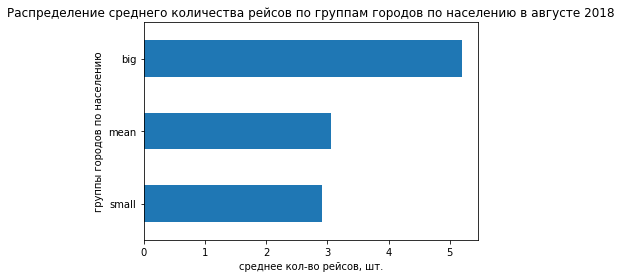

In [74]:
(city_without_cap.pivot_table(index='qcut_city_group', values='average_flights', aggfunc='mean')
 .sort_values('average_flights')
 .plot.barh(legend=False))
plt.title('Распределение среднего количества рейсов по группам городов по населению в августе 2018')
plt.xlabel('среднее кол-во рейсов, шт.')
plt.ylabel('группы городов по населению')
plt.show()

Группы стали уже чуть крупнее и даже больше 30 наблюдений!))

Результат похож на интуитивно ожидаемый, чем крупнее город, тем больше рейсов совершается из него. Есть, конечно, и исключения, типа Советского или Мирного.

## Вывод

**По среднему количеству рейсов**, естественно, лидируют города федерального значения, находящиеся в европейской части России - Москва и Санкт-Петербург. 
Далее, опять же ожидаемо, и объяснимо географическими особенностями расположения, идут города-центры Сибири и Урала: Новосибирск, Красноярск и Екатеринбург. 

В целом можно сказать, что чем крупнее город, тем больше рейсов из него совершается. Но есть и исключения, типа Советского и Мирного, их них совершается много рейсов (скорее всего на самолетах малой вместительности) в соседние области и регионы, где отсутствует другой способ транспортного сообщения. 


**По количеству рейсов за месяц среди анализируемых моделей самолетов** лидирует "Cessna 208 Caravan" (4500 рейсов), это самолет для перевозки малого количества (9-13) людей, в связи с чем, пассажиропоток за месяц небольшой. Скорее всего именно Cessna используется для полетов в Советском и Мирном (но это не точно!).

Хорошие показатели, как по количеству рейсов, так и по пассажиропотоку у "Bombardier CRJ-200" и "Sukhoi SuperJet-100", 4400 рейсов/220 тыс.человек и 4100 рейсов/410 тыс.человек, соответственно. Они используются для региональных перевозок. 

На самолетах бОльшей вместимости (около 150 - 250 человек) количество рейсов за сентябрь 2018 года меньше 1 000. 

Аэробусы А321-200, А319-100 и Боинг 737-300 можно сказать, что это аналоги Бомбардира и Суперджета, но для направлений с меньшим пассажиропотоком и спросом. Пассажиропоток за месяц от 180 до 80 тыс. человек.

Меньше всего рейсов совершалось на Боингах 767 и 777. Рейсов хоть и мало, но за счет большой вместительности пассажиропоток не самый маленький (170 - 130 тыс.человек). Такие модели целесообразны в использовании для перелетов между большими транспортными узлами. 